In [1]:
# Importing required libraried

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset
import torch
from torch import nn
import torch.optim as optim
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import seaborn as sns

# Checking if GPU is available
print(torch.cuda.is_available())
device = 'cuda'

True


In [2]:
# Applying Data Augumentation and downloading Training and Testing Data
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

train = SVHN(root = 'data/', download = True, split = 'train', transform = train_transform)
test = SVHN(root = 'data/', download = True, split = 'test', transform = test_transform)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

#### Data Visualization

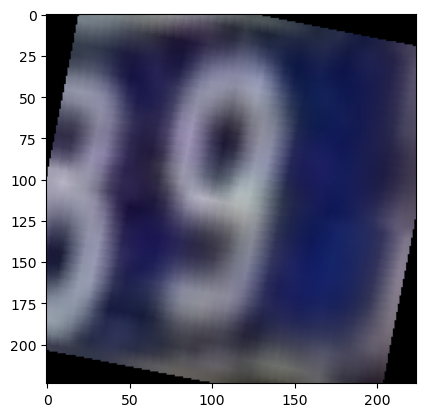

In [3]:
# Normalized image plot

img = train[50][0]
img = np.array(img)
img = np.transpose(img, (1, 2, 0))
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

plt.imshow(img)
plt.show()

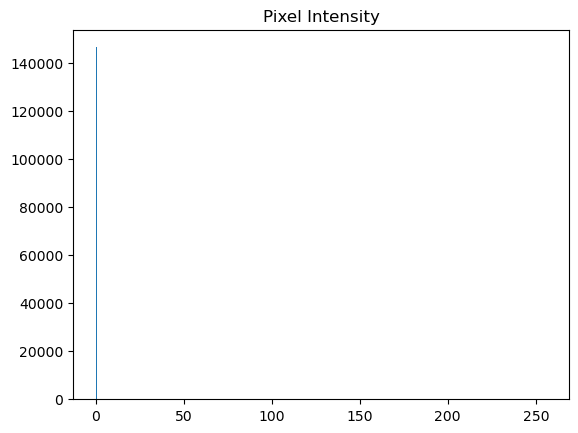

/opt/conda/lib/python3.7/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


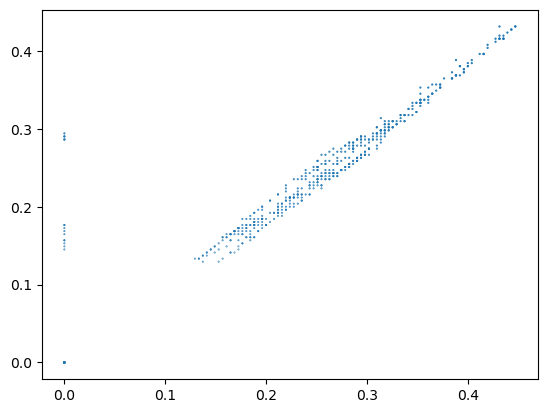

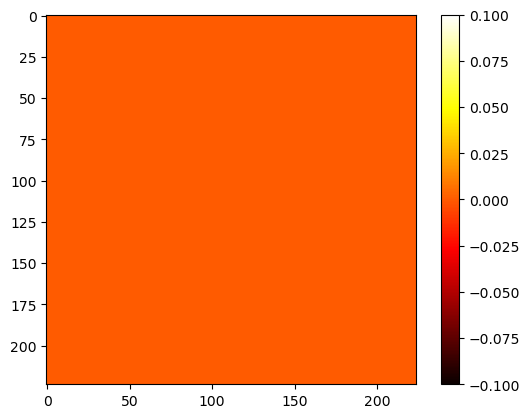

In [4]:
# Histogram of pixel intensities

plt.hist(x=img.ravel(), bins=256, range=[0, 256])
plt.title("Pixel Intensity")
plt.show()

plt.scatter(img[10], img[11], img[12])
plt.show()

image = np.zeros([224, 224], dtype=np.uint8)
for i in range(224):
    for j in range(224):
        avg = (0.2126 * img[i][j][0] + 0.7152 * img[i][j][1] + 0.0722 * img[i][j][2])
        image[i][j] = avg

plt.imshow(image, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [5]:
split_valid = int(len(train) * 0.2) # Calculating 20% of the total data to split the 20% of Validation data
split_train = len(train) - split_valid # Rest of data to Train(80%)
data_train, data_valid = random_split(train, [split_train, split_valid])

class AlexNet(nn.Module):
    def __init__(self, no_of_class=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, no_of_class),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [8]:
# Setting the hyperparameters
num_classes = 10
epochs = 15
batch_size = 64
learning_rate = 0.005
patience = 2
history = []

# Initializing model, loss function, and optimizer
model = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)

# Splitting the dataset into training and validation sets
split_valid = int(len(train) * 0.2)
split_train = len(train) - split_valid
data_train, data_valid = random_split(train, [split_train, split_valid])

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Training the model
best_loss = float('inf')
early_stop_count = 0
loss_valid = []
loss_train = []

for epoch in range(epochs):
    train_loss = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    epoch_train_loss = sum(train_loss) / len(train_loss)
    loss_train.append(epoch_train_loss)
    print(f"Epoch {epoch+1}: Training Loss = {epoch_train_loss:.4f}")

    with torch.no_grad():
        valid_loss = 0.0
        valid_acc = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            valid_acc += torch.sum(preds == labels).item()
        valid_loss /= len(valid_loader)
        valid_acc /= len(data_valid)
        loss_valid.append(valid_loss)
    
        print(f"Epoch {epoch+1}: Validation Loss = {valid_loss:.4f}, Validation Accuracy = {valid_acc:.4f}%")

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model.state_dict()
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Validation loss hasn't improved in {patience} epochs. Stopping early!!!")
            break

Epoch 1: Training Loss = 2.1204
Epoch 1: Validation Loss = 1.9989, Validation Accuracy = 0.47%
Epoch 2: Training Loss = 1.8678
Epoch 2: Validation Loss = 1.7355, Validation Accuracy = 0.75%
Epoch 3: Training Loss = 1.6652
Epoch 3: Validation Loss = 1.6355, Validation Accuracy = 0.84%
Epoch 4: Training Loss = 1.6186
Epoch 4: Validation Loss = 1.6091, Validation Accuracy = 0.86%
Epoch 5: Training Loss = 1.6002
Epoch 5: Validation Loss = 1.6043, Validation Accuracy = 0.87%
Epoch 6: Training Loss = 1.5905
Epoch 6: Validation Loss = 1.5958, Validation Accuracy = 0.88%
Epoch 7: Training Loss = 1.5846
Epoch 7: Validation Loss = 1.5865, Validation Accuracy = 0.89%
Epoch 8: Training Loss = 1.5787
Epoch 8: Validation Loss = 1.5815, Validation Accuracy = 0.90%
Epoch 9: Training Loss = 1.5740
Epoch 9: Validation Loss = 1.5816, Validation Accuracy = 0.90%
Epoch 10: Training Loss = 1.5711
Epoch 10: Validation Loss = 1.5780, Validation Accuracy = 0.90%
Epoch 11: Training Loss = 1.5676
Epoch 11: Valid

In [12]:
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
model_test = AlexNet(num_classes).to(device)
model_test.load_state_dict(best_model)
model_test.eval()

with torch.no_grad():
    test_loss = 0
    test_acc = 0
    for batch in test_loader:
        image, label = batch
        image = image.to(device)
        label = label.to(device)

        output = model_test(image)
        loss = criterion(output, label)
        test_loss += loss.item() * image.size(0)

        y_pred = torch.argmax(output, dim=1)
        acc = (y_pred == label).float().mean().item() * 100
        test_acc += acc * image.size(0)

    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_acc:.4f}%")


Testing Loss: 1.5405, Testing Accuracy: 93.1392%


Text(0, 0.5, 'Loss')

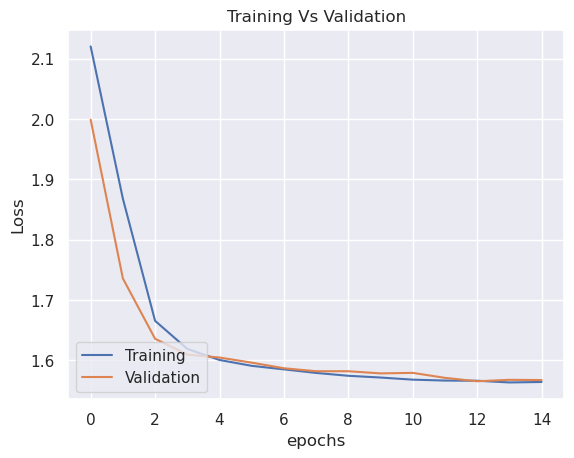

In [16]:
# Plotting the training and validation accuracy
plt.plot(loss_train)
plt.plot(loss_valid)
plt.legend(["Training", "Validation"], loc ="lower left")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Loss")

### References
1. https://medium.com/prathmesh-bhansali/exploring-svhn-using-deep-neural-network-1213959db92c
2. https://www.tensorflow.org/tutorials/load_data/images
3. https://www.tensorflow.org/tutorials/images/classification
4. https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
5. https://www.tensorflow.org/
6. https://keras.io/